<a href="https://colab.research.google.com/github/nhjung-phd/TimeSeriesAnalysis/blob/main/R/04_ARIMA_forecasting_R.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# 시계열 예측 백테스트 (R) — Full-sample / Fixed-origin / Rolling / Expanding

이 노트북은 **Box–Jenkins(ARIMA)** 프레임워크를 바탕으로 다음 4가지 평가/운영 방식을 R로 구현합니다.

1. **Full-sample(final fit)**: 전체 표본으로 최종 적합 후 미래 구간 예측 (평가용 X, 리포팅/배포 전 최종 적합)
2. **Fixed-origin(holdout)**: 기준시점 N 고정(예: 80%), 그 이전으로 적합 → 그 이후 전 구간을 **한 번에** 예측
3. **Rolling-origin + Rolling window**: 원점이 1스텝씩 이동, **고정 길이 W 창**으로 재적합하여 1-step 예측 반복
4. **Rolling-origin + Expanding window(=Recursive)**: 원점이 1스텝씩 이동, **누적 창**으로 재적합하여 1-step 예측 반복

> 데이터: Yahoo Finance에서 TSLA 종가를 수집합니다.


In [11]:

# ---- 패키지 설치 & 로드 ------------------------------------------------------
pkgs <- c("quantmod","forecast","ggplot2","dplyr","tibble","tidyr","scales")
new <- pkgs[!(pkgs %in% installed.packages()[,1])]
if (length(new)) install.packages(new, repos = "https://cloud.r-project.org")

suppressPackageStartupMessages({
  library(quantmod)
  library(forecast)
  library(ggplot2)
  library(dplyr)
  library(tibble)
  library(tidyr)
  library(scales)
})

# 경고 최소화(필요 시 해제 가능)
options(warn = -1)
set.seed(42)


In [12]:
options(repr.plot.width = 12, repr.plot.height = 6, repr.plot.res = 150)

In [13]:

# ---- 데이터 로드 -------------------------------------------------------------
symbol     <- "TSLA"
start_date <- "2022-01-01"
end_date   <- "2024-01-01"

getSymbols(symbol, src = "yahoo", from = start_date, to = end_date, auto.assign = TRUE)
px_xts <- get(symbol)
df <- tibble(Date = index(px_xts), Close = as.numeric(Cl(px_xts))) %>% drop_na()
print(head(df, 3))
cat("Rows:", nrow(df), "\n")


[1] "TSLA"

# A tibble: 3 × 2
  Date       Close
  <date>     <dbl>
1 2022-01-03  400.
2 2022-01-04  383.
3 2022-01-05  363.
Rows: 501 


In [14]:

# ---- 학습/테스트 분할 (80/20) ------------------------------------------------
n <- nrow(df)
split_idx <- floor(n * 0.8)
train <- df[1:split_idx, , drop = FALSE]
test  <- df[(split_idx + 1):n, , drop = FALSE]

y_train <- train$Close
y_test  <- test$Close
dates_test <- test$Date

cat(sprintf("Train=%d | Test=%d\n", length(y_train), length(y_test)))


Train=400 | Test=101


In [15]:

# ---- 유틸리티 함수 -----------------------------------------------------------
rmse <- function(a, b) sqrt(mean((a - b)^2, na.rm = TRUE))
mae  <- function(a, b) mean(abs(a - b), na.rm = TRUE)
r2   <- function(a, b) {
  ss_res <- sum((a - b)^2, na.rm = TRUE)
  ss_tot <- sum((a - mean(a, na.rm = TRUE))^2, na.rm = TRUE)
  1 - ss_res/ss_tot
}

safe_auto_arima <- function(y, max.p=5, max.q=5, max.d=1) {
  # max.d=1로 제한 → 과도한 차분(d>=2)에서의 drift 경고 회피
  suppressWarnings(
    tryCatch(
      auto.arima(y, seasonal = FALSE, stepwise = TRUE, approximation = FALSE,
                 max.p = max.p, max.q = max.q, max.d = max.d,
                 allowdrift = TRUE, allowmean = TRUE, biasadj = FALSE),
      error = function(e) NULL
    )
  )
}

one_step_forecast <- function(y, fit=NULL, max.p=5, max.q=5, max.d=1) {
  # fit이 없으면 새로 auto.arima 실행
  if (is.null(fit)) {
    fit <- safe_auto_arima(y, max.p=max.p, max.q=max.q, max.d=max.d)
  }
  if (is.null(fit)) {
    # 실패 시 간단한 평균 대체
    k <- min(10, length(y))
    return(mean(tail(y, k)))
  }
  as.numeric(forecast::forecast(fit, h = 1)$mean)
}



## 1) Full-sample (final fit)

전체 표본 `1…T`에 ARIMA를 적합하고, 이후 `T+1…T+h`를 예측합니다.  
> 성능평가 용도(X), **최종 리포팅/배포 전** 마지막 적합에 사용.


Series: y 
ARIMA(0,1,0) 

sigma^2 = 83.44:  log likelihood = -1815.5
AIC=3633   AICc=3633.01   BIC=3637.22

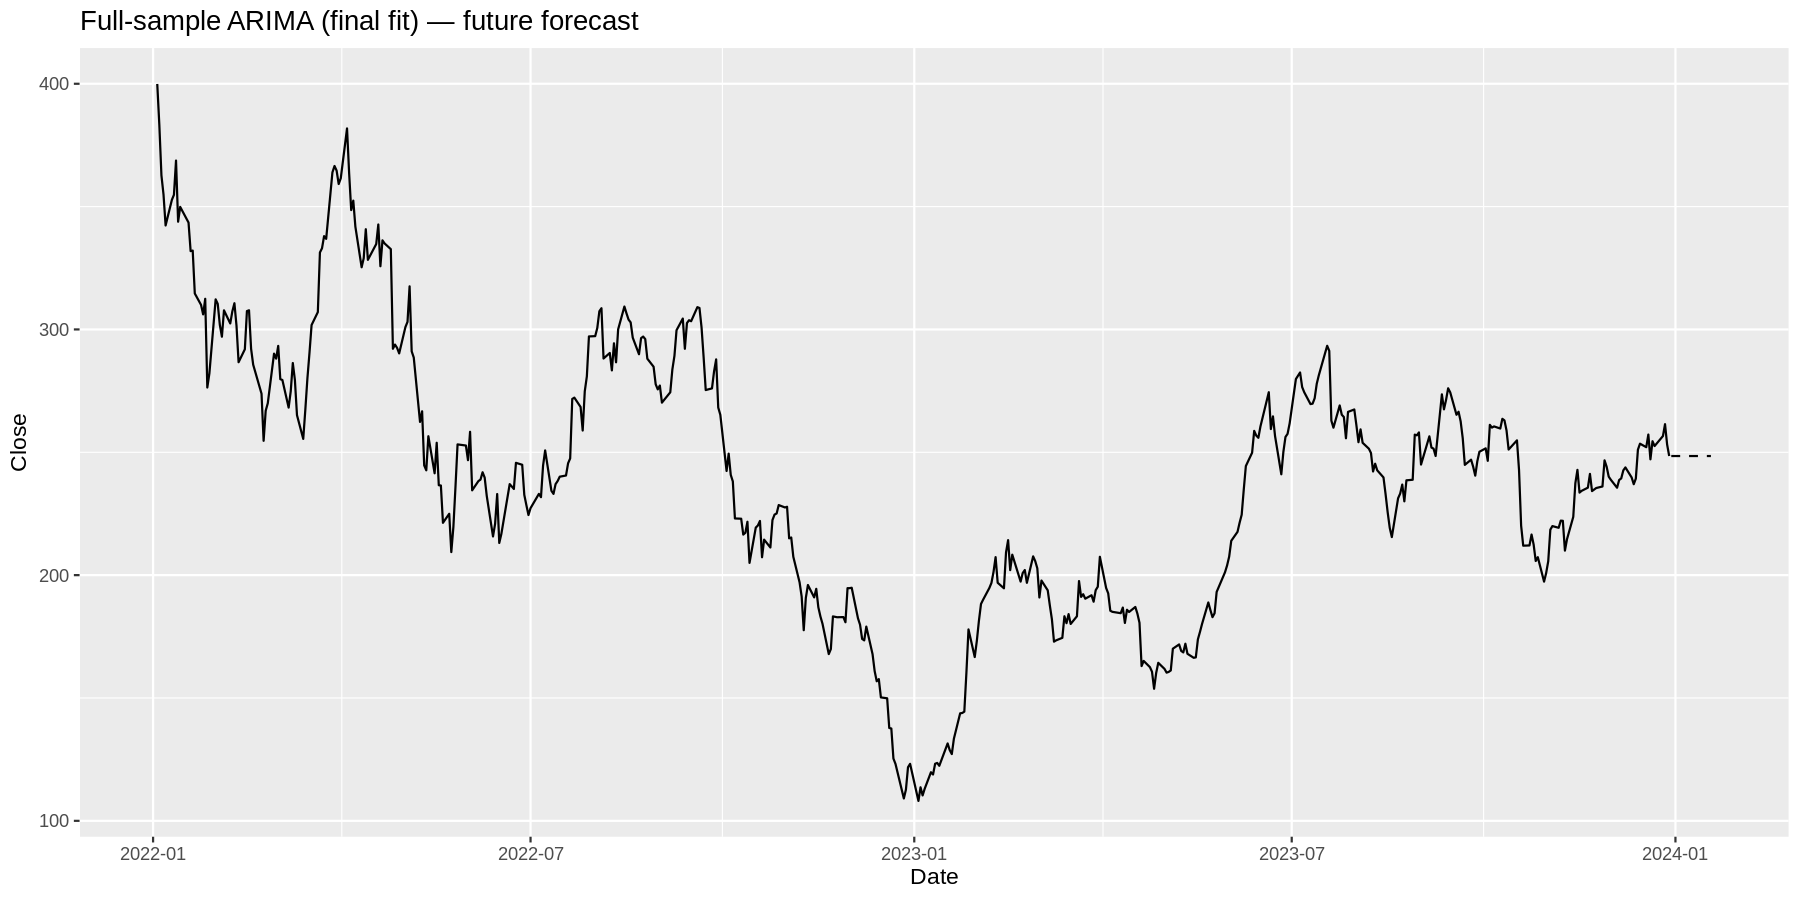

In [16]:

h <- 20  # 미래 예측 길이
fit_full <- safe_auto_arima(df$Close, max.p = 5, max.q = 5, max.d = 1)
fit_full

future_fc <- if (!is.null(fit_full)) forecast::forecast(fit_full, h = h)$mean else rep(mean(tail(df$Close,10)), h)
future_fc <- as.numeric(future_fc)

future_dates <- seq(from = max(df$Date) + 1, by = "day", length.out = h)
plot_full <- df %>%
  ggplot(aes(Date, Close)) +
  geom_line(color = "black") +
  geom_line(data = tibble(Date=future_dates, Close=future_fc),
            aes(Date, Close), linetype="dashed") +
  labs(title = "Full-sample ARIMA (final fit) — future forecast",
       x = "Date", y = "Close")
print(plot_full)



## 2) Fixed-origin (single-origin / holdout)

기준 시점 `N=⌊0.8T⌋`에서 **한 번만** 적합하고, `N+1…T` 전체를 **한 번에** 예측합니다.  
> 빠르고 재현성 높음. 베이스라인/간단 홀드아웃 평가에 적합.


[Fixed-origin] RMSE=19.9963 | MAE=15.2640 | R2=-0.3170


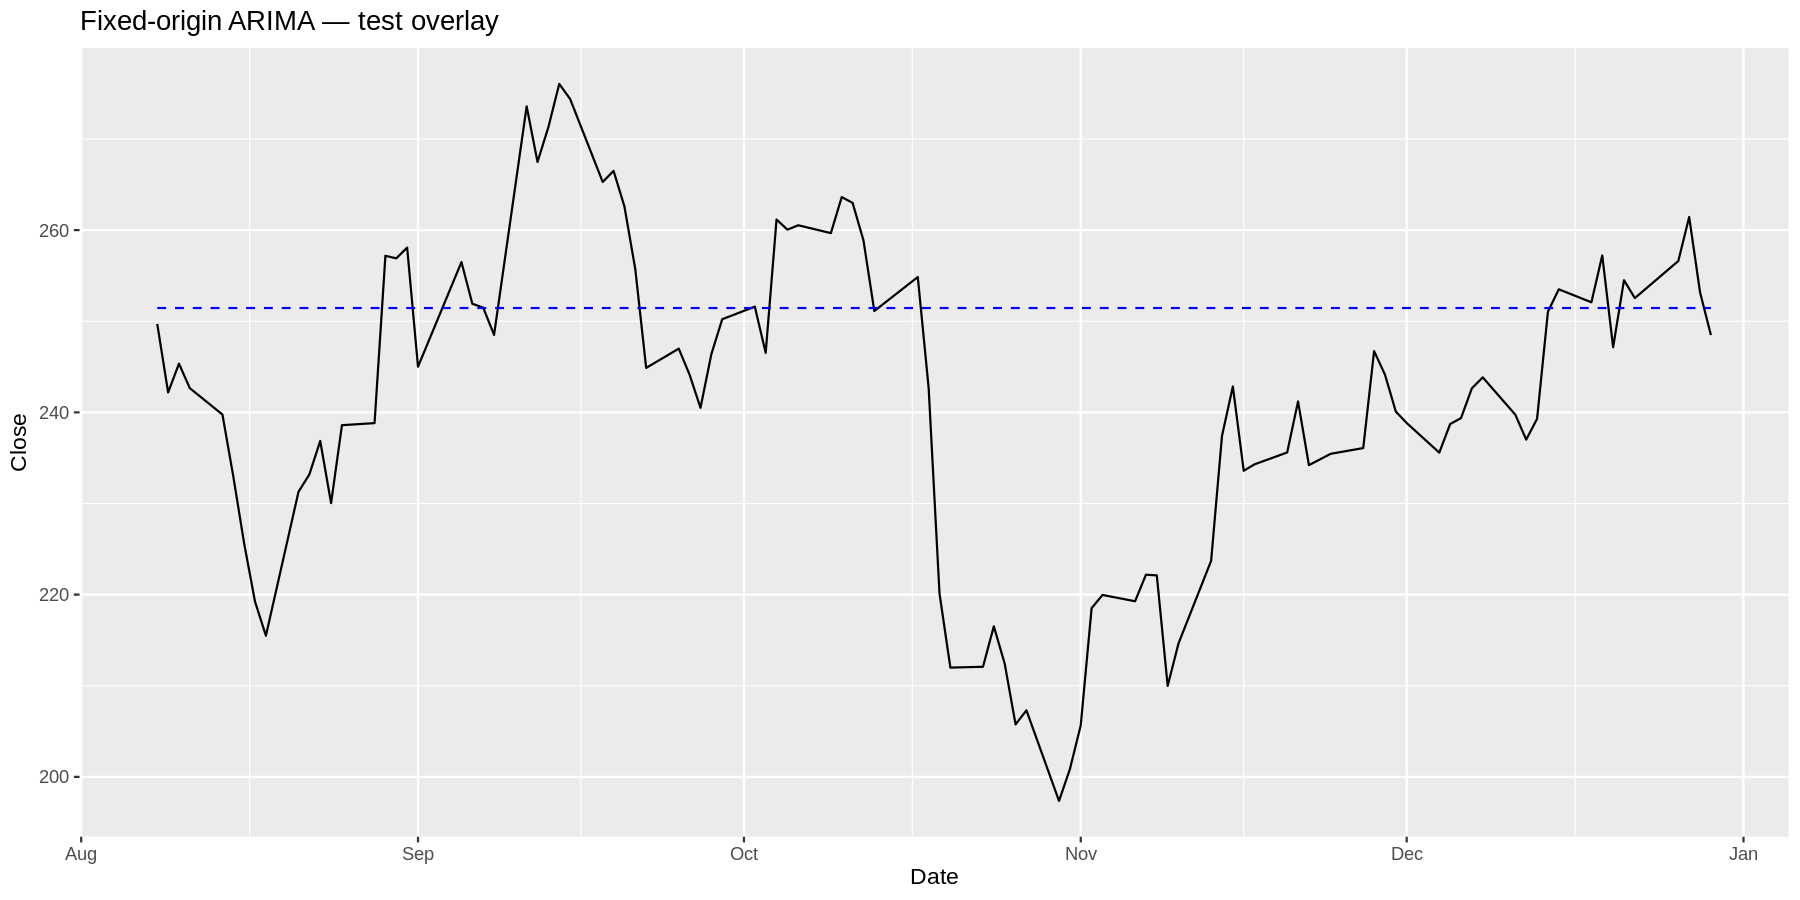

In [17]:

fit_fixed <- safe_auto_arima(y_train, max.p = 5, max.q = 5, max.d = 1)
fc_fixed  <- if (!is.null(fit_fixed)) forecast::forecast(fit_fixed, h = length(y_test))$mean else rep(mean(tail(y_train,10)), length(y_test))
fc_fixed  <- as.numeric(fc_fixed)

rmse_fx <- rmse(y_test, fc_fixed)
mae_fx  <- mae(y_test,  fc_fixed)
r2_fx   <- r2(y_test,   fc_fixed)
cat(sprintf("[Fixed-origin] RMSE=%.4f | MAE=%.4f | R2=%.4f\n", rmse_fx, mae_fx, r2_fx))

df_fx <- tibble(Date = dates_test, Actual = y_test, Pred = fc_fixed)
ggplot(df_fx, aes(Date)) +
  geom_line(aes(y = Actual), color = "black") +
  geom_line(aes(y = Pred), linetype = "dashed", color = "blue") +
  labs(title = "Fixed-origin ARIMA — test overlay", x = "Date", y = "Close")



## 3) Rolling-origin + Rolling window

원점(예측 기준 시점)을 한 스텝씩 이동시키며, **고정 길이 W**의 최근 창으로 매번 재적합 → 1-step ahead 예측을 반복합니다.  
> 최신 정보에 민감(드리프트 대응), 오래된 데이터는 버립니다.


[Rolling window] RMSE=19.8639 | MAE=15.5361 | R2=-0.2996


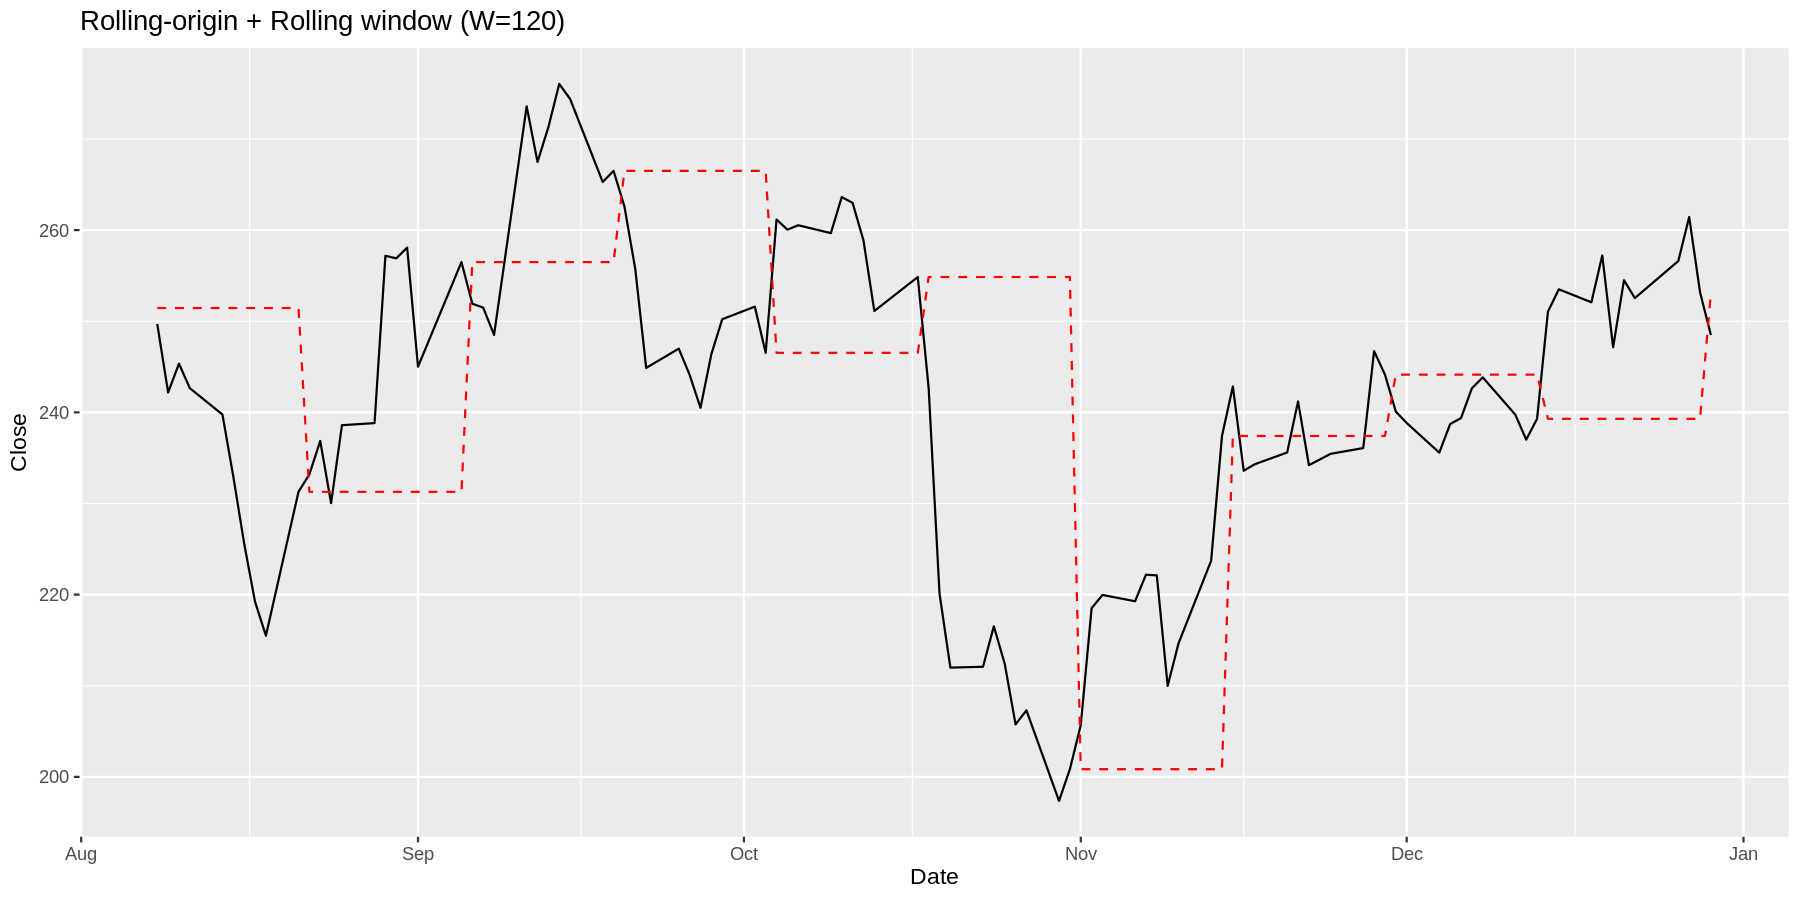

In [18]:

W <- 120L            # 창 길이
stride <- 10L        # 매 stride 스텝마다 모형 재선택
pred_roll <- rep(NA_real_, length(y_test))

hist <- y_train
current_fit <- NULL

for (i in seq_along(y_test)) {
  y_win <- if (length(hist) >= W) tail(hist, W) else hist
  # 주기적 재적합
  if (is.null(current_fit) || ((i - 1) %% stride) == 0) {
    current_fit <- safe_auto_arima(y_win, max.p=5, max.q=5, max.d=1)
  }
  # 1-step 예측
  pred_roll[i] <- one_step_forecast(y_win, fit = current_fit, max.p=5, max.q=5, max.d=1)
  # 워크-포워드: 실제값 주입
  hist <- c(hist, y_test[i])
}

rmse_rl <- rmse(y_test, pred_roll)
mae_rl  <- mae(y_test,  pred_roll)
r2_rl   <- r2(y_test,   pred_roll)
cat(sprintf("[Rolling window] RMSE=%.4f | MAE=%.4f | R2=%.4f\n", rmse_rl, mae_rl, r2_rl))

df_rl <- tibble(Date = dates_test, Actual = y_test, Pred = pred_roll)
ggplot(df_rl, aes(Date)) +
  geom_line(aes(y = Actual), color = "black") +
  geom_line(aes(y = Pred), linetype = "dashed", color = "red") +
  labs(title = sprintf("Rolling-origin + Rolling window (W=%d)", W), x = "Date", y = "Close")



## 4) Rolling-origin + Expanding window (Recursive)

원점은 한 스텝씩 이동하지만, 추정창은 **처음부터 t까지 누적**되어 점점 커져 갑니다.  
> 데이터 축적 효과로 안정적(분산↓), 구조변화 적응은 다소 느릴 수 있음.


[Expanding window] RMSE=19.8639 | MAE=15.5361 | R2=-0.2996


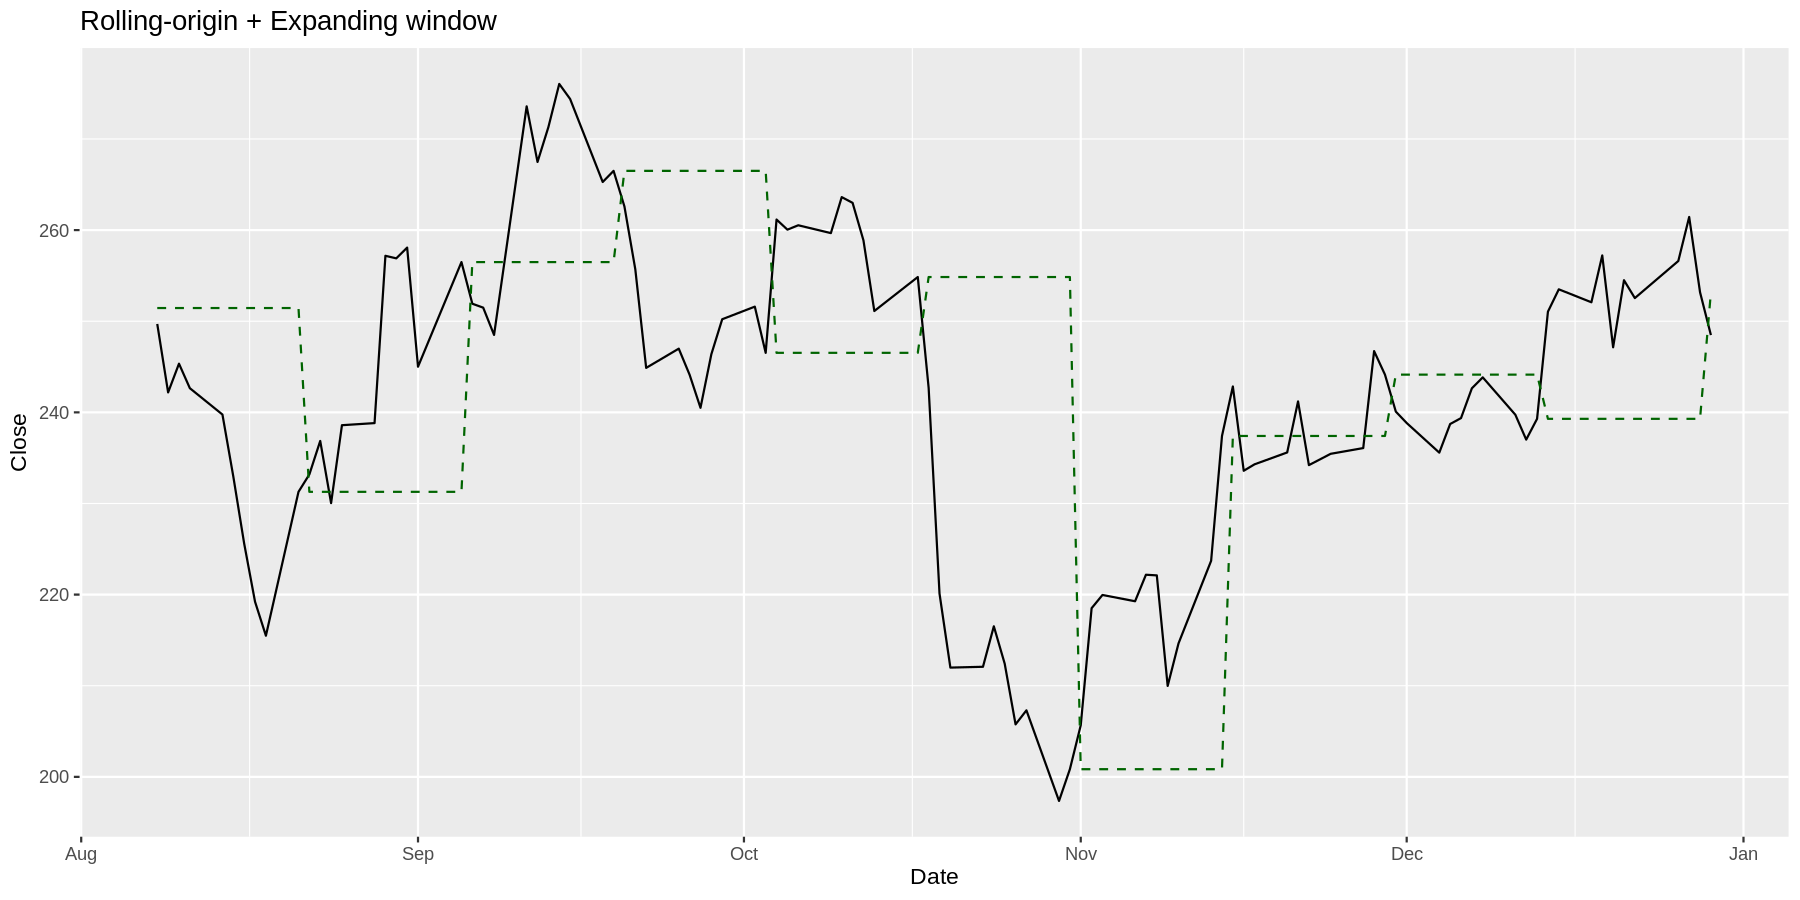

In [19]:

stride <- 10L        # 매 stride 스텝마다 모형 재선택
pred_exp <- rep(NA_real_, length(y_test))

hist <- y_train
current_fit <- NULL

for (i in seq_along(y_test)) {
  # 주기적 재적합(누적 창)
  if (is.null(current_fit) || ((i - 1) %% stride) == 0) {
    current_fit <- safe_auto_arima(hist, max.p=5, max.q=5, max.d=1)
  }
  # 1-step 예측
  pred_exp[i] <- one_step_forecast(hist, fit = current_fit, max.p=5, max.q=5, max.d=1)
  # 워크-포워드: 실제값 누적
  hist <- c(hist, y_test[i])
}

rmse_ex <- rmse(y_test, pred_exp)
mae_ex  <- mae(y_test,  pred_exp)
r2_ex   <- r2(y_test,   pred_exp)
cat(sprintf("[Expanding window] RMSE=%.4f | MAE=%.4f | R2=%.4f\n", rmse_ex, mae_ex, r2_ex))

df_ex <- tibble(Date = dates_test, Actual = y_test, Pred = pred_exp)
ggplot(df_ex, aes(Date)) +
  geom_line(aes(y = Actual), color = "black") +
  geom_line(aes(y = Pred), linetype = "dashed", color = "darkgreen") +
  labs(title = "Rolling-origin + Expanding window", x = "Date", y = "Close")



## 성능 요약 & 오버레이


# A tibble: 3 × 4
  Method            RMSE   MAE     R2
  <chr>            <dbl> <dbl>  <dbl>
1 Rolling window    19.9  15.5 -0.300
2 Expanding window  19.9  15.5 -0.300
3 Fixed-origin      20.0  15.3 -0.317


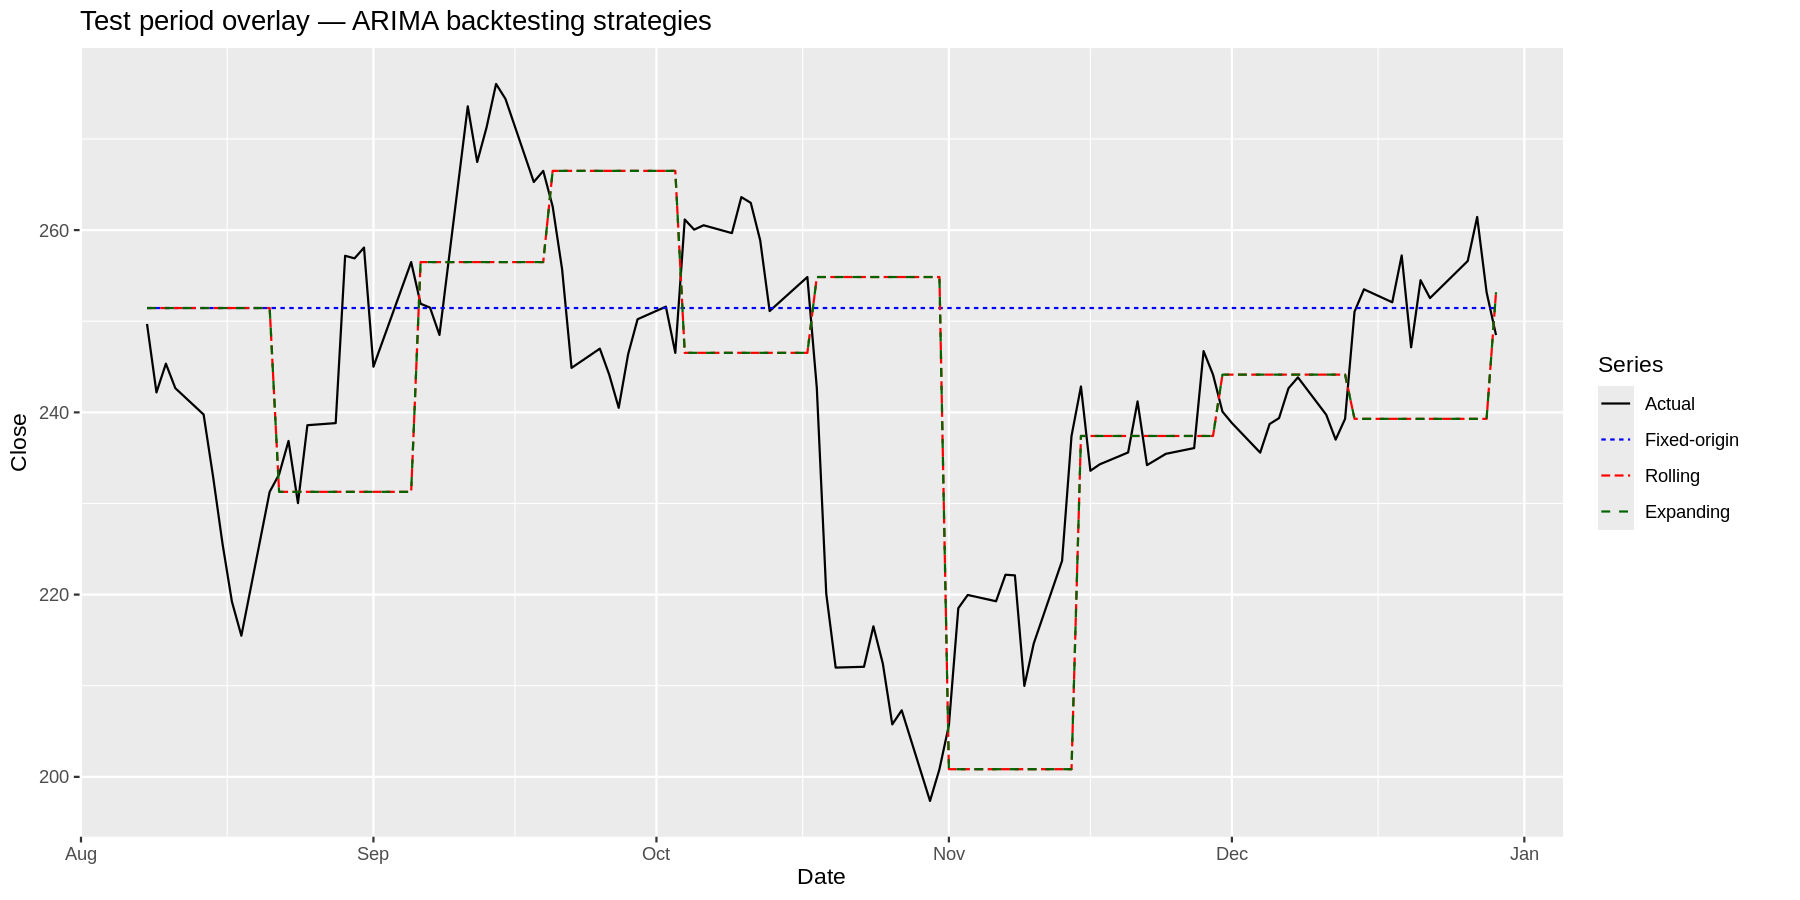

In [20]:

summary_tbl <- tibble::tibble(
  Method = c("Fixed-origin", "Rolling window", "Expanding window"),
  RMSE   = c(rmse_fx, rmse_rl, rmse_ex),
  MAE    = c(mae_fx,  mae_rl,  mae_ex),
  R2     = c(r2_fx,   r2_rl,   r2_ex)
) %>% arrange(RMSE)
print(summary_tbl)

overlay_df <- tibble(
  Date   = rep(dates_test, 4),
  Value  = c(y_test, pred_roll, pred_exp, as.numeric(fc_fixed)),
  Series = factor(rep(c("Actual","Rolling","Expanding","Fixed-origin"),
                      each = length(y_test)),
                  levels = c("Actual","Fixed-origin","Rolling","Expanding"))
)

ggplot(overlay_df, aes(Date, Value, color = Series, linetype = Series)) +
  geom_line() +
  scale_color_manual(values = c("Actual"="black","Fixed-origin"="blue",
                                "Rolling"="red","Expanding"="darkgreen")) +
  labs(title = "Test period overlay — ARIMA backtesting strategies",
       x = "Date", y = "Close")
